In [2]:
from bartpy.sklearnmodel import SklearnModel
import gc, argparse, sys, os, errno
from functools import reduce
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from scipy import io
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

from collections import defaultdict
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
from statsmodels.robust.scale import mad
from scipy.stats import pearsonr

random_state = np.random.RandomState(1289237)  


Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [3]:
cd ..

/Users/james/Desktop/四春/A5图像处理/大作业2/DIP_final


In [4]:
def prepare_dataset(datafile='data/BoW_Training.mat',valid_method = 'classic',train_context_num=5):
    import scipy.io as sio
    BoW_Training = sio.loadmat(datafile)['data']
    print (BoW_Training.shape)
    BoW_Training_x = BoW_Training[:,:50]
    BoW_Training_y = BoW_Training[:,-2:]
    if valid_method == 'classic':
        return train_test_split(BoW_Training_x, BoW_Training_y, test_size=0.2, random_state=42)
    elif valid_method =='non-iid':
        '''
        split the dataset so for each class, split 7 contexts into 5:2, 
        predict 2 contexts corresponding class
        '''
        tmp_select_ind = np.array([]).astype('int')
        for i in np.unique(BoW_Training_y[:,0]):
            #print (np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]))
            tmp_context_ind = np.random.choice(np.unique(BoW_Training_y[:,1][BoW_Training_y[:,0] ==i]),
                             train_context_num,replace=False,)
            tmp_select_ind = np.concatenate((tmp_select_ind,np.where( (BoW_Training_y[:,0]==i)& 
                                (np.isin(BoW_Training_y[:,1],tmp_context_ind )==1) )[0]  ))

        train_ind = tmp_select_ind
        test_ind = np.setdiff1d(np.arange(0,BoW_Training_y.shape[0]),tmp_select_ind)
        return BoW_Training_x[train_ind],BoW_Training_x[test_ind],BoW_Training_y[train_ind],\
                BoW_Training_y[test_ind],train_ind,test_ind
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler

X_train, X_test, y_train, y_test,_,_ = prepare_dataset(datafile='data/BoW_Training.mat',
                                                        valid_method = 'non-iid',
                                                         train_context_num=5)
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))


(4156, 52)
number of training samples: 2956, test samples: 1200


In [5]:
y_train = y_train[:,0]
y_test = y_test[:,0]

In [6]:
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler
X_train = preprocess(X_train,method='robust')[0]
X_test =  preprocess(X_test,method='robust')[0]

In [7]:
def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average=None),
           'precision': precision_score(y_test, y_pred,average=None),
           'f1': f1_score(y_test, y_pred,average=None),
           'mcc': matthews_corrcoef(y_test, y_pred)
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))
    return scorers['f1'],scorers['accuracy'],scorers['recall'],scorers['precision'],scorers['mcc']

def report_metrics_plot(y_test, y_pred):
    fig, ax = plt.subplots(1,2,figsize=(6,5))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

In [8]:
report_metrics_plot(y_test, (out_of_sample_predictions).astype('int'))

NameError: name 'out_of_sample_predictions' is not defined

In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from stability_selection import StabilitySelection



/Users/james/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
base_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty='l1'))
])

## Here stability selection is instantiated and run
selector = StabilitySelection(base_estimator=base_estimator, lambda_name='model__C',
                              lambda_grid=np.logspace(-5, -1, 5)).fit(X_train, y_train)

print(selector.get_support(indices=True))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 25
 27 28 29 32 33 35 36 37 38 41 42 43 45 47 48 49]


In [18]:
selector.get_support(indices=True).shape

(40,)

In [22]:
selector.stability_scores_.max(axis=1)

array([0.63, 0.8 , 0.9 , 0.97, 1.  , 0.99, 0.95, 0.94, 0.92, 1.  , 0.99,
       0.69, 1.  , 0.89, 0.88, 0.73, 0.61, 0.96, 0.85, 1.  , 1.  , 0.73,
       0.34, 0.84, 0.57, 0.92, 0.4 , 0.9 , 1.  , 0.84, 0.57, 0.56, 1.  ,
       0.93, 0.37, 0.88, 0.95, 0.9 , 1.  , 0.39, 0.57, 0.99, 0.97, 1.  ,
       0.55, 0.87, 0.16, 0.88, 0.95, 0.99])

In [23]:
# Inherently multiclass:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC #(setting multi_class=”crammer_singer”)
from sklearn.linear_model import LogisticRegression #(setting multi_class=”multinomial”)
from sklearn.linear_model import LogisticRegressionCV #(setting multi_class=”multinomial”)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
# Multiclass as One-Vs-One:
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier #(setting multi_class = “one_vs_one”)
# Multiclass as One-Vs-All:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier #(setting multi_class = “one_vs_rest”)
from sklearn.svm import LinearSVC #(setting multi_class=”ovr”)
from sklearn.linear_model import LogisticRegression #(setting multi_class=”ovr”)
from sklearn.linear_model import LogisticRegressionCV #(setting multi_class=”ovr”)
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

models_all = {'BernoulliNB':BernoulliNB(),
            'DecisionTreeClassifier':DecisionTreeClassifier(),
            'ExtraTreeClassifier':ExtraTreeClassifier(),  
            'ExtraTreesClassifier':ExtraTreesClassifier(),
            'GaussianNB':GaussianNB(),
            'KNeighborsClassifier':KNeighborsClassifier(),
            'LabelPropagation':LabelPropagation(),
            'LabelSpreading':LabelSpreading(),
            'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'LinearSVC': LinearSVC(multi_class='crammer_singer'),
            'LogisticRegression':LogisticRegression('multinomial'),
            'LogisticRegressionCV':LogisticRegressionCV('multinomial'),
            'MLPClassifier':MLPClassifier(),
            'NearestCentroid':NearestCentroid(),
            'QuadraticDiscriminantAnalysis':QuadraticDiscriminantAnalysis(),
            'RandomForestClassifier':RandomForestClassifier(),
            'RidgeClassifier':RidgeClassifier(),
            'RidgeClassifierCV':RidgeClassifierCV(),
            'NuSVC': NuSVC(),
            'SVC':SVC(),
            'GaussianProcessClassifier':GaussianProcessClassifier(multi_class = 'one_vs_one'),
            'GradientBoostingClassifier':GradientBoostingClassifier(),
            'GaussianProcessClassifier':GaussianProcessClassifier(multi_class = 'one_vs_rest'),
            'LinearSVC':LinearSVC(multi_class='ovr'),
            'LogisticRegression':LogisticRegression(multi_class='ovr'),
            'LogisticRegressionCV':LogisticRegressionCV(multi_class='ovr'),
            'SGDClassifier':SGDClassifier(),
            'Perceptron':Perceptron(),
            'PassiveAggressiveClassifier':PassiveAggressiveClassifier()                       
}

In [24]:
def Model(width,height,modelname):
    '''
    if modelname=='lr':
        model = LogisticRegression()
    elif modelname=='svm':
        model = SVC()
    elif modelname=='xgb':
        model = GradientBoostingClassifier()
    elif modelname=='kn':
        model = neighbors.KNeighborsClassifier(n_neighbors=4, algorithm='brute')
    elif modelname=='rf':
        model = RandomForestClassifier(n_estimators=10,  max_depth=12, n_jobs=5)
    elif modelname=='gp':
        kernel = 1.0 * DotProduct(sigma_0=1.0)**4
        model = GaussianProcessClassifier(kernel = kernel, optimizer=None,verbose=1)
    elif modelname=='mlp':
        model = MLPClassifier(verbose=1)
    '''
    model = models_all[modelname]
    
    print (model)
    model.fit(X_train, y_train)
    print ('finish training')
    y_pred = model.predict(X_test)
    
    fig, ax = plt.subplots(1,2,figsize=(width,height))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

In [26]:
def Model_select_feature(width,height,modelname):
    '''
    if modelname=='lr':
        model = LogisticRegression()
    elif modelname=='svm':
        model = SVC()
    elif modelname=='xgb':
        model = GradientBoostingClassifier()
    elif modelname=='kn':
        model = neighbors.KNeighborsClassifier(n_neighbors=4, algorithm='brute')
    elif modelname=='rf':
        model = RandomForestClassifier(n_estimators=10,  max_depth=12, n_jobs=5)
    elif modelname=='gp':
        kernel = 1.0 * DotProduct(sigma_0=1.0)**4
        model = GaussianProcessClassifier(kernel = kernel, optimizer=None,verbose=1)
    elif modelname=='mlp':
        model = MLPClassifier(verbose=1)
    '''
    model = models_all[modelname]
    
    print (model)
    model.fit(X_train[:,select_ind], y_train)
    print ('finish training')
    y_pred = model.predict(X_test[:,select_ind])
    
    fig, ax = plt.subplots(1,2,figsize=(width,height))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

In [25]:
interact(Model,modelname= Dropdown(options=[i for i in models_all.keys()],value='LogisticRegression'),
                width =FloatSlider(min=12,max=24,step=2,value=15),
                 height= FloatSlider(min=4,max=8,step=2,value=5),
        )

interactive(children=(FloatSlider(value=15.0, description='width', max=24.0, min=12.0, step=2.0), FloatSlider(…

<function __main__.Model(width, height, modelname)>

In [33]:
select_ind = np.where(selector.stability_scores_.max(axis=1)>=0.5)[0]

In [34]:
interact(Model_select_feature,modelname= Dropdown(options=[i for i in models_all.keys()],value='LogisticRegression'),
                width =FloatSlider(min=12,max=24,step=2,value=15),
                 height= FloatSlider(min=4,max=8,step=2,value=5),
        )

interactive(children=(FloatSlider(value=15.0, description='width', max=24.0, min=12.0, step=2.0), FloatSlider(…

<function __main__.Model_select_feature(width, height, modelname)>

Selected variables are:
-----------------------
Variable 1: [0], score 0.630
Variable 2: [1], score 0.800
Variable 3: [2], score 0.900
Variable 4: [3], score 0.970
Variable 5: [4], score 1.000
Variable 6: [5], score 0.990
Variable 7: [6], score 0.950
Variable 8: [7], score 0.940
Variable 9: [8], score 0.920
Variable 10: [9], score 1.000
Variable 11: [10], score 0.990
Variable 12: [11], score 0.690
Variable 13: [12], score 1.000
Variable 14: [13], score 0.890
Variable 15: [14], score 0.880
Variable 16: [15], score 0.730
Variable 17: [16], score 0.610
Variable 18: [17], score 0.960
Variable 19: [18], score 0.850
Variable 20: [19], score 1.000
Variable 21: [20], score 1.000
Variable 22: [21], score 0.730
Variable 23: [23], score 0.840
Variable 24: [25], score 0.920
Variable 25: [27], score 0.900
Variable 26: [28], score 1.000
Variable 27: [29], score 0.840
Variable 28: [32], score 1.000
Variable 29: [33], score 0.930
Variable 30: [35], score 0.880
Variable 31: [36], score 0.950
Variable 3

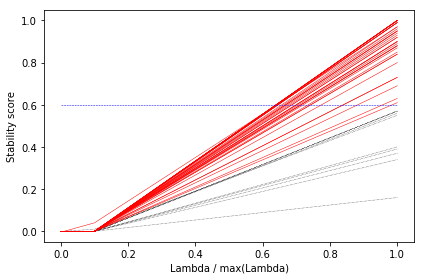

In [14]:
from stability_selection import StabilitySelection, plot_stability_path
fig, ax = plot_stability_path(selector)
fig.show()

selected_variables = selector.get_support(indices=True)
selected_scores = selector.stability_scores_.max(axis=1)

print('Selected variables are:')
print('-----------------------')

for idx, (variable, score) in enumerate(zip(selected_variables, selected_scores[selected_variables])):
    print('Variable %d: [%d], score %.3f' % (idx + 1, variable, score))


In [15]:
selector.predict(X_test)

AttributeError: 'StabilitySelection' object has no attribute 'predict'

In [ ]:
selector = StabilitySelection(base_estimator=base_estimator,
                              lambda_name='model__C',
                              lambda_grid=np.logspace(-5, -1, 5),
                              bootstrap_func='complementary_pairs')
selector.fit(X, y)